In [1]:
import tensorflow as tf, matplotlib
print("TF", tf.__version__, "| logical devices ➜", tf.config.list_logical_devices())
# Expect only CPU devices listed

TF 2.16.2 | logical devices ➜ [LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [2]:
import pathlib, shutil

RAW_DIR  = pathlib.Path("kaggle")          # folder you downloaded / unzipped
WORK_DIR = pathlib.Path("data/images")     # Keras-friendly layout

for cls in ("cats", "dogs"):
    (WORK_DIR/cls).mkdir(parents=True, exist_ok=True)

for img in RAW_DIR.rglob("*.jpg"):
    low = img.name.lower()
    if low.startswith("cat") or "cat." in low:
        shutil.copy2(img, WORK_DIR/"cats"/img.name)
    elif low.startswith("dog") or "dog." in low:
        shutil.copy2(img, WORK_DIR/"dogs"/img.name)

print("Cats:", len(list((WORK_DIR/'cats').iterdir())),
      "| Dogs:", len(list((WORK_DIR/'dogs').iterdir())))

Cats: 500 | Dogs: 500


In [3]:
IMG_FOLDER = "data/images"
IMG_SIZE   = (128, 128)   # keep RAM usage low
BATCH      = 8
SEED       = 123

train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_FOLDER, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH)

val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_FOLDER, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH)

class_names = train_raw.class_names
print("Classes ➜", class_names)

train_ds, val_ds = train_raw, val_raw    # no prefetch on CPU


Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Classes ➜ ['cats', 'dogs']


In [4]:
from tensorflow.keras import layers, models, callbacks

# data-augmentation block (runs only during training)
data_aug = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augment")

model = models.Sequential([
    data_aug,
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    layers.Conv2D(16, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/anaconda3/envs/cnn_cpu_env/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augment (Sequential)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
early = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

EPOCHS = 25          # will stop sooner when val-loss stops improving
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early],
    verbose=2
)


Epoch 1/25
100/100 - 3s - 28ms/step - accuracy: 0.5437 - loss: 0.6959 - val_accuracy: 0.4350 - val_loss: 0.7089
Epoch 2/25
100/100 - 2s - 22ms/step - accuracy: 0.5188 - loss: 0.6934 - val_accuracy: 0.4350 - val_loss: 0.7090
Epoch 3/25
100/100 - 2s - 22ms/step - accuracy: 0.5487 - loss: 0.6869 - val_accuracy: 0.5350 - val_loss: 0.6691
Epoch 4/25
100/100 - 2s - 22ms/step - accuracy: 0.5950 - loss: 0.6808 - val_accuracy: 0.6600 - val_loss: 0.6703
Epoch 5/25
100/100 - 2s - 23ms/step - accuracy: 0.5987 - loss: 0.6685 - val_accuracy: 0.5600 - val_loss: 0.6688
Epoch 6/25
100/100 - 2s - 24ms/step - accuracy: 0.5763 - loss: 0.6792 - val_accuracy: 0.5400 - val_loss: 0.6690
Epoch 7/25
100/100 - 2s - 24ms/step - accuracy: 0.6037 - loss: 0.6646 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 8/25
100/100 - 3s - 31ms/step - accuracy: 0.6125 - loss: 0.6625 - val_accuracy: 0.6000 - val_loss: 0.6566
Epoch 9/25
100/100 - 2s - 23ms/step - accuracy: 0.6300 - loss: 0.6337 - val_accuracy: 0.5100 - val_loss:

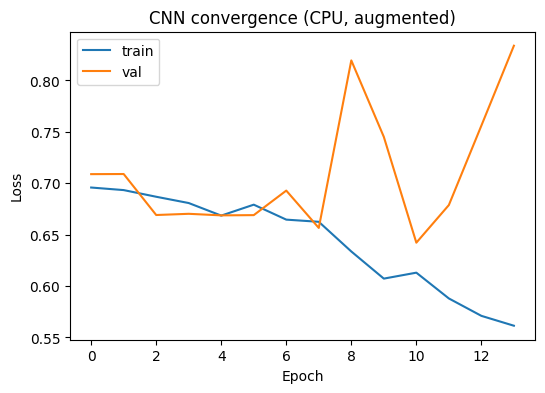

Model saved as cnn_cats_dogs_cpu.keras ✔️


In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],     label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('CNN convergence (CPU, augmented)'); plt.legend(); plt.show()

model.save("cnn_cats_dogs_cpu.keras")   # new Keras v3 format
print("Model saved as cnn_cats_dogs_cpu.keras ✔️")